# Public contracting in Colombia

### Juan Camilo Azuero
University of Colorado Boulder

## Abstract

The purpose of this study is to diagnose public contracting in Colombia, and identify unusual contracting patterns that generate suspicion of fraud. The proposed investigation was built using a public dataset that contains all <a href="https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Contratos-Electr-nicos/jbjy-vk9h">public contracts from the SECOP II platform</a> available in a open data repository of the Colombian government. Secop II is a public contracting platform launched by the Colombian government in 2015 looking to integrate all contracting processes in a single IT system.<br>
This work is carried out as part of the course "Data Mining Prject" from the University of Colorado Boulder, and includes data extraction and cleaning, an Exploratory Data Analysis, the construction of a machine learning model that predicts contract value, and the use of the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN</a> algorithm for outlier detection in contracting patterns. In this investigation it was found that the multiple public datasets about contracting are filled with inconsistencies and require a lot of cleaning and processing which ideally should be carried out by the Colombian government so that the datsets available are ready to use. It was also found that most of public contracts signed in Colombia are provision of services contracts under the figure of direct contracting, which is not advisable. The investigation also produce a set of outlier contractors that deserve further attention to check for possible irregularities.

## Imports and setup

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import itertools
from wordcloud import WordCloud

<IPython.core.display.Javascript object>

In [6]:
warnings.filterwarnings("ignore")

In [7]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

## Introduction

The nation's comptroller general found that every year Colombians lose approximately 50 trillion pesos (close to 15 billion USD) due to corruption. This amount is equivalent to 17% of the nation's general budget and is one of the main factors why almost half of the population in Colombia lives in poverty. Confronting this scourge is extremely important since the impact on citizens is very negative. Looking to fight this problem, the colombian government created the SECOP (Sistema Electronico de Contratación Pública) II platform which is intended to manage all information related to public contracting in Colombia. This public platform has information of more than one million public contracts signed since it was launched in 2015. Most public entities in Colombia still use the old SECOP I platform, but are tarnsitioning into the new information managemente system and should finish this process in the near future. In this project the contracts from SECOP II will be analyzed using data science techniques in order to characterize public contracting in Colombia and find posible abnormalities.<br>
For the development of the project, Python was used due to its ease of use and the large number of data science tools available, including <a href="https://kedro.readthedocs.io/en/stable/">Kedro</a> a data science framework on which the development was carried out. This framework was selected because it allows to create "reproducible, maintainable and modular data science code". One nice feature of kedro is that it allows to create a visualization of the different modules that compose the data pipeline. The next figure displays the data extraction and processing functions (marked with an f) used in the project.

![img1](../data/08_reporting/kedro_viz.png "Kedro Viz")

All the code, including instructions on how to reproduce the results, can be found in <a href="https://github.com/jcazuero94/DM_project"> github</a>. 

## Related work

Although reducing the waste of public resources is of great importance, there is no tool that can timely identify contracting irregularities. There are <a href="https://repository.ugc.edu.co/bitstream/handle/11396/3852/SECOP_urna_cristal _gerencia_electr%C3%B3nica.pdf">academic works</a>  that deeply analyze the public contracting system, but do not consider the detail of each process in their analysis. Dashboards have also been built, such as <a href="https://tablerocontratacion.colombiacompra.gov.co/">Colombia Compra Eficiente</a>, which superficially summarize the basis of contracting processes, but do not reach a sufficient level of detail to identify abnormal contracting patterns. The purpose of this project is to deepen the analyzes previously carried out using data science tools such as machine learning, so that irregularities can be identified in a timely manner.

## Data extraction, cleaning and processing

### Extraction

The extraction process was implemented incrementaly using the Socrata API made available by the colombian government. The data from public contracts requested at extraction include contracting entity, contracted person or company, type of contract, contracted value, and start and end dates of the contract. This information is then saved in a parquet format for further processing.<br>
The DANE (Departamento Administrativo Nacional de Estadística) was also used as a source for <a href="https://www.dane.gov.co/index.php/estadisticas-por-tema/cuentas-nacionales/cuentas-nacionales-departamentales">economic variables of the different states fo Colombia</a>.

### Cleaning

The extensive cleaning process is carried out in the node clean_secop_2_cont from the data engineering pipeline, and can be detailed in the notebook CleanSecop2_cont.ipynb available in the code repository. Some of the steps undertaken include:
* Standarization of texts including the transformation into lower case and the removal of spanish accentuation (tildes). 
* Gouping of categorical variables like the type of contract and provider type
* Removal of inter-administrative agreements between public entities
* Deletion of contracts that have not been signed
* General cleaning of of inconsistencies like fake identification numbers and contracts with negative value
* The object and description of the contract were processed to be used as input in the proposed models. 

### Processing

The cleaned SECOP II dataset was then processed to be used in the different models. This processing included the removal of punctuation symbols and stopwords, the lemmatization of each word for the object and description of the contract, the creation of dummy variables from catagorical features, and the creation of a provider dataset.<br>
The description of the contract was concatenated with the object of the contract and was then vectorized using TfIdf vectorization and a word to vec model. The Term Frequency - Inverse Document Frequency vectorization technique is a method that takes a description and produces a vector with the required length, where each vector component is proportional to the number of times that term appear in the description and is penalized for the amount of contract descriptions containing the word. This technique does not consider the order of the words and produces a single vector for each contract.<br>
A word to vec model that transforms each word into a 300-dimensional vector that encodes its meaning was also used. This model relies on large neural networks trained on enormous corpuses of text in order to do feature selection. For this study the <a href="https://huggingface.co/fse/word2vec-google-news-300">word 2 vec 300 from google news</a> was selected, as it is trained in a very large corpus and has achieved surprisingly good results at encoding the syntactic and semantic meaning of words.

#### Provider dataset

A dataset with a summary about providers was constructed from the SECOP II cleaned table. This dataset groups the distinct signed contracts for each provider and includes the following aggregated information:
* Provider ID
* Provider Type
* Number of contracts
* Number of different public entities that related with the provider
* Number of different cities where the provider has contracted
* Total value contracted
* Days since first contract
* Average contract extension days
* Maximum number of simultaneous active contracts
* Mean aggregation resulting from dimensionality reduction of other important attributes. This includes attributes encoding the economic dynamics of the state and information encoded in the contact description.

## Exploratory data analysis

In [15]:
def prop_counts(ser: pd.Series):
    vc = ser.value_counts()
    res = vc / vc.sum()
    return (res * 100).apply(lambda x: str(int(np.round(x, 0))) + "%")

<IPython.core.display.Javascript object>

### SECOP II contracts

Load data

In [9]:
secop = catalog.load("secop_2_cont_clean")

[08/15/22 16:15:57] INFO     Loading data from 'secop_2_cont_clean' (ParquetDataSet)...         ]8;id=266219;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=919506;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

<IPython.core.display.Javascript object>

There are approximately 1,650,000 contracts registered in SECOP II at the date of extraction (august 5 of 2022). 84% of these contracts correspond to people while only 16% are related to business

In [21]:
len(secop)

1645036

<IPython.core.display.Javascript object>

In [22]:
prop_counts(secop["tipodocproveedor"])

cedula de ciudadania    84%
nit                     16%
Otro                     0%
Name: tipodocproveedor, dtype: object

<IPython.core.display.Javascript object>

Almost 80% of the contracts in SECOP II correspond to the type direct hiring. his is not a recomended practice, and is only allowed on exceptional cases. <a href="http://www.secretariasenado.gov.co/senado/basedoc/ley_1150_2007.html">Reference in spanish.</a>

In [23]:
prop_counts(secop["modalidad_de_contratacion"])

contratacion directa    79%
regimen especial        11%
menor cuantia            8%
subasta                  1%
licitacion publica       0%
concurso meritos         0%
otro                     0%
Name: modalidad_de_contratacion, dtype: object

<IPython.core.display.Javascript object>

The amount of contracts registered in the platform increases steadily since its inception and has a very notorious peak in january of 2022. This peak is consequence of the <a href="https://www.portafolio.co/economia/en-vispera-a-ley-de-garantias-se-quintuplico-la-contratacion-561050">*Ley de Garantías*</a> which prohibits public direct contracting since 4 months before presidential elections until the election is concluded. This law was created to protect elections from possible manipulation by the government through the unjustified delivery of public contracts, but as the data shows, it produces a concentration of contracts prior to the application of the law.

[<matplotlib.lines.Line2D object at 0x4969c8e50>]

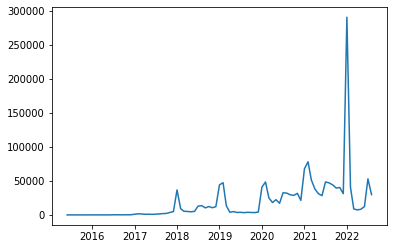

<IPython.core.display.Javascript object>

In [28]:
secop["year_fecha_de_firma"] = pd.DatetimeIndex(secop["fecha_de_firma"]).year
secop["month_fecha_de_firma"] = pd.DatetimeIndex(secop["fecha_de_firma"]).month
secop["year_month_fecha_de_firma"] = secop.apply(
    lambda row: datetime.date(
        row["year_fecha_de_firma"], row["month_fecha_de_firma"], 1
    ),
    axis=1,
)
plt.plot(
    secop[["year_month_fecha_de_firma", "referencia_del_contrato"]]
    .groupby("year_month_fecha_de_firma")
    .count()
)

The distribution of contracted value is vey skewed as most contracts are direct hiring for less than 50 million pesos (around 12 thousand dolars). This price is one of the variables of interest, so in order to model it as needed, a log transformation was carried out.

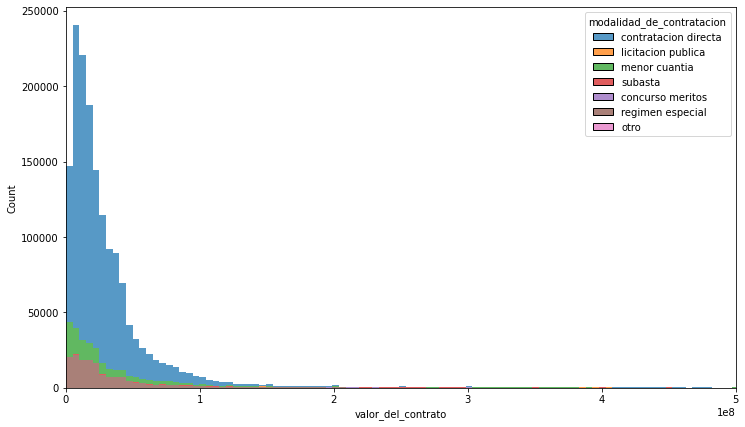

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plt.subplots()
sns.histplot(
    data=secop,
    x="valor_del_contrato",
    bins=700000,
    hue="modalidad_de_contratacion",
    common_norm=False,
    ax=ax,
    multiple="stack",
)
ax.set_xlim(0, 500000000)
fig.set_size_inches(12, 7)

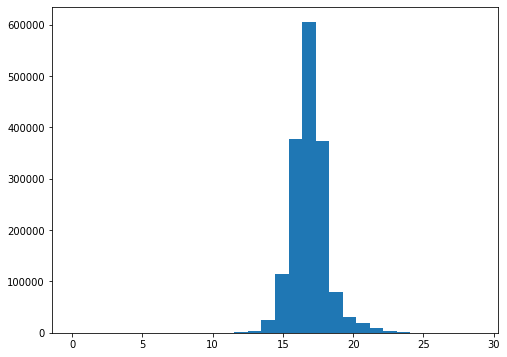

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots()
ax.hist(secop["log_valor_del_contrato"], bins=30)
fig.set_size_inches(8, 6)

A large number of direct hire contracts last 6 months or one year. This is because the operation of a lot of public entities relies on provision of services contracts which are usually awareded the public sector through direct contracting for a term of 6 months or 1 year.

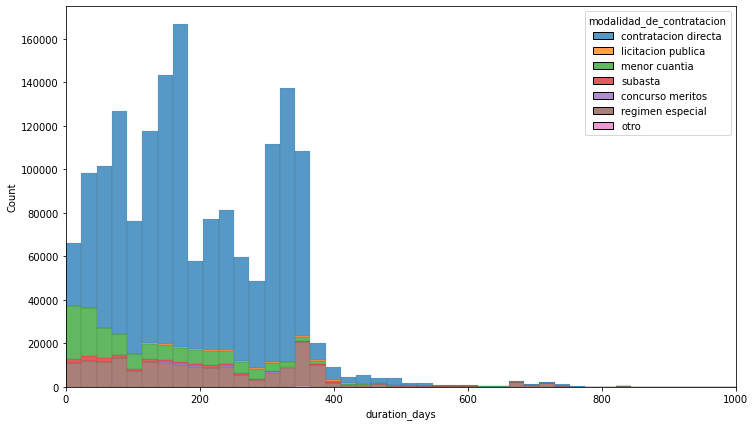

<IPython.core.display.Javascript object>

In [45]:
fig, ax = plt.subplots()
sns.histplot(
    data=secop,
    x="duration_days",
    bins=480,
    hue="modalidad_de_contratacion",
    # stat="probability",
    common_norm=False,
    ax=ax,
    multiple="stack",
)
ax.set_xlim(0, 1000)
fig.set_size_inches(12, 7)

A word cloud was used to explore the contract descriptions. Many of the terms displayed are related to work and the provision of professional services

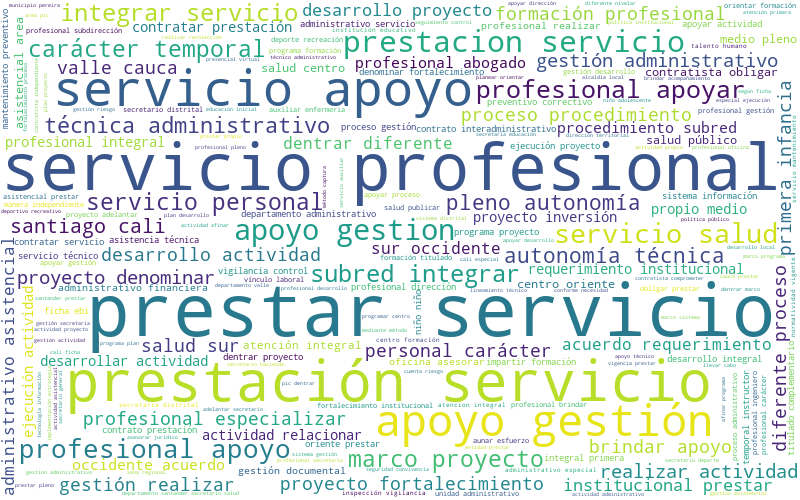

<IPython.core.display.Javascript object>

In [53]:
words = list(
    itertools.chain(
        *secop["full_contract_description"].apply(lambda x: x.split(" ")).values
    )
)
word_cloud = WordCloud(background_color="White", height=500, width=800)
wc = word_cloud.generate_from_text(" ".join(words))
wc.to_image()

### SECOP II providers

#### People

In [100]:
df_personas = catalog.load("df_personas")

[08/15/22 18:25:17] INFO     Loading data from 'df_personas' (ParquetDataSet)...                ]8;id=544935;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=71887;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

<IPython.core.display.Javascript object>

While 67% of the providers have more than one registered contract on secop II, only around 11% of them has had more than 1 contract active at some time since the platform is active. 90% of the providers only has contracted in one city, while 84% of them have only signed contracts with one public entity. Less than 1% of the contractors have worked in more than 2 cities and less than 4% have contracts with 3 or more public entities.

In [101]:
res = pd.DataFrame()
res["Number of contracts"] = prop_counts(df_personas["index"]).head(10)
res["Number of simultaneous contracts"] = prop_counts(
    df_personas["date_duration"]
).head(10)
res["Cities"] = prop_counts(df_personas["ciudad"]).head(10)
res["Public Entities"] = prop_counts(df_personas["nombre_entidad"]).head(10)
res

,Number of contracts,Number of simultaneous contracts,Cities,Public Entities
1,34%,89%,90%,84%
2,23%,10%,9%,12%
3,18%,1%,1%,2%
4,11%,0%,0%,1%
5,6%,0%,0%,0%
6,4%,0%,0%,0%
7,2%,0%,0%,0%
8,1%,0%,0%,0%
9,1%,0%,0%,0%
10,0%,0%,0%,0%


<IPython.core.display.Javascript object>

In [131]:
print(
    str(int(np.round((df_personas["dias_adicionados"] > 0).mean() * 100, 0)))
    + "% of the contracts were extended and lasted more than originally intended.\n"
    + "The average contract extension is of "
    + str(
        np.round(
            df_personas[df_personas["dias_adicionados"] > 0]["dias_adicionados"].mean(),
            2,
        )
    )
    + " days"
)

31% of the contracts were extended and lasted more than originally intended.
The average contract extension is of 30.13 days


<IPython.core.display.Javascript object>

The average number of days the contracts were extended for each contractor has a large spread, and present natural peaks in multiples of 15 days.

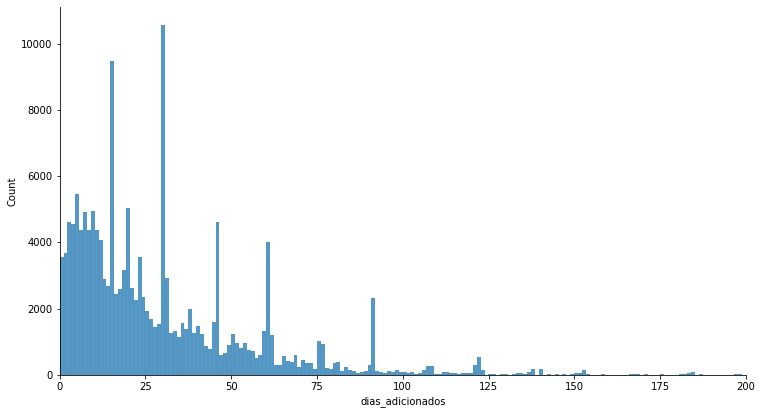

<IPython.core.display.Javascript object>

In [118]:
sns.displot(
    df_personas[df_personas["dias_adicionados"] > 0]["dias_adicionados"],
)
ax = plt.gca()
ax.set_xlim(0, 200)
fig = plt.gcf()
fig.set_size_inches(12, 6)

#### Business

In [119]:
df_empresas = catalog.load("df_empresas")

[08/15/22 18:33:26] INFO     Loading data from 'df_empresas' (ParquetDataSet)...                ]8;id=833029;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=312604;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

<IPython.core.display.Javascript object>

While 61% of the providers have more than one registered contract on secop II, around half of them has had more than 1 contract active at some time since the platform is active. Business providers behave differently from people and contact on multiple locations. While 90% of individual contactors has contracted in one city, this number descends to 73% when analysing businesses. Around 67% of enterprise contactors have only signed contracts with one public entity.

In [120]:
res = pd.DataFrame()
res["Number of contracts"] = prop_counts(df_empresas["index"]).head(10)
res["Number of simultaneous contracts"] = prop_counts(
    df_empresas["date_duration"]
).head(10)
res["Cities"] = prop_counts(df_empresas["ciudad"]).head(10)
res["Public Entities"] = prop_counts(df_empresas["nombre_entidad"]).head(10)
res

,Number of contracts,Number of simultaneous contracts,Cities,Public Entities
1,39%,66%,73%,67%
2,18%,15%,14%,14%
3,11%,6%,5%,6%
4,7%,3%,2%,3%
5,5%,2%,1%,2%
6,3%,1%,1%,1%
7,2%,1%,1%,1%
8,2%,1%,0%,1%
9,1%,1%,0%,1%
10,1%,0%,0%,1%


<IPython.core.display.Javascript object>

In [132]:
print(
    str(int(np.round((df_empresas["dias_adicionados"] > 0).mean() * 100, 0)))
    + "% of the contracts were extended and lasted more than originally intended.\n"
    + "The average contract extension is of "
    + str(
        np.round(
            df_empresas[df_empresas["dias_adicionados"] > 0]["dias_adicionados"].mean(),
            2,
        )
    )
    + " days"
)

34% of the contracts were extended and lasted more than originally intended.
The average contract extension is of 36.36 days


<IPython.core.display.Javascript object>

The distribution of the number of extension days for companies is different than from people. The figure below shows that the very notorious peaks of extensions seen in the previous histogram are not as prominent when contracting with business. One possible explanation of this pattern is that public entities rely on extensions of service provider contracts for their operation, while extensions in contracts with business are the consequence of contingencies at the time of execution.

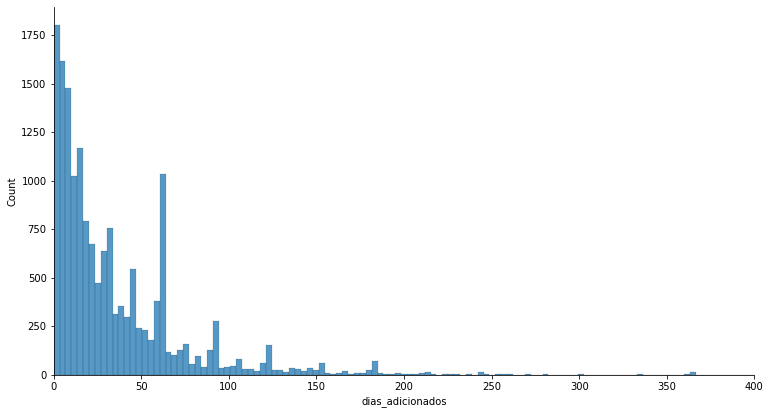

<IPython.core.display.Javascript object>

In [123]:
sns.displot(
    df_empresas[df_empresas["dias_adicionados"] > 0]["dias_adicionados"],
)
ax = plt.gca()
ax.set_xlim(0, 400)
fig = plt.gcf()
fig.set_size_inches(12, 6)

## Modelling and evaluation

The following section presents the two main models constructed in this project. The first model relies on the SECOP II cleaned contract dataset and predicts the log of the price contacted based on other attributes. The second model is based on the DBSCAN algorithm and is used to detect abnormal contracting patterns from providers. 

### Price model

Multiple price predicting models were constructed in the course of the investigation. The first step for model construction was to split the dataset into train, validation and test sets. This was done making sure that contracts from the same process belong to the same partition so that there are no data leaks into the validation  and test set. <br>
For the construction of this model different classes and architechtures were tested. This tests included recurrent neural networks based on the word 2 vec vectorization of the contract description, and regular dense neural networks trained and random forests using the TfIdf vectorization. The RNNs tested included simple RNNs, LSTMs and bi-directional LSTMs, were very expensive to train and did not achieve the results obtained by the algorithms using the TfIdf vectorization. Further experimentation using different architechtures and hyperparameters should be carried out in the future.

#### Dense neural network

Multiple forward neural networks were tested for price prediction. The number of parameters of the test models ranged between 40,000 and 250,000 and the number of hidden layers ranged between 3 and 5. All these models were trained using the ADAM (adaptive moment) optimizer and the mean squared error loss, and were evaluated with the root mean squared error over the validation set. The model that achieved the best results includes 5 hidden layers, each but the last followed by a dropout layer and all of them except the first are preceded by a batch normalization layer. The final architechture of the model contains 139,231 trainable parameters and is shown below.

<p style="text-align: center;">Model summary</p>

![img2](../data/08_reporting/NN_architecture.png "NN architecture")

This neural network obtained a root mean squared error of 1.34 regarding the logarithm of the price and required around 450 epochs for the training.

<p style="text-align: center;">RMSE</p>

![img2](../data/08_reporting/NN_training.png "NN training")

#### Random forest regressor

A random forest regressor was also constructed using the TfIdf vectorization. The code related to the training can be found in the notebook PriceModel.ipynb. This estimator was trained using cross-validation over the number of trees, the maximum depth of the trees, the minimum number of samples in a leaf and the maximum amount of features considered when splitting. The regressor produced by this process obtained a root mean squared error of 0.94 in the validation dataset and a similar score in the test dataset. The following two plots display the observed vs predicted log of the contract value and the dispersion of errors.

<p style="text-align: center;">Observed vs predicted</p>

![img3](../data/08_reporting/pred_vs_true_RF.png "RF results") 

<p style="text-align: center;">Dispersion of errors</p>

![img3](../data/08_reporting/ERR_RF.png "RF Error dispersion") 

Using Shapely Additive values feature importance and contribution was explored. This methodology allows to estimate the marginal additive contribution of each feature for every prediction. More information about the topic is available <a href="https://christophm.github.io/interpretable-ml-book/shapley.html">here</a>. The next Figure displays the shapely values calculated for the test set. Each point in the graph represents an atribute of a single observation where the color encodes the value of the attribute and the posotion of the x-axis represents the contribution toward the prediction. This means that the width of the point cloud can be interpreted as feature importance and when red points are at the right of the figure there is a positive relation while red points at the left implies an inverse relation. The dispresion of points of similar color is product of the feature interactions present in the model. The SHAP analysis indicates that the model predicts a higher price for longer contract durations and that direct hiring and lower bidding are related with lower costs than other contract types.

![img3](../data/08_reporting/SHAP.png "RF Error dispersion") 

### Provider outlier detection

The second model constructed was unsupervised, and relied on the DBSCAN algorithm to find outliers in the contractors dataset. The features used to fit the DBSCAN model were the total amount of contracts, the number of days since the first registered contract of the provider, the mean number of extension days, the maximum number of simulteneous contracts, the inverse of the number of public entities that signed with the contractor, 1 divided by the number of different cities where contracts took place and 10 attributes resulting of the dimensionality reduction of other secondary attributes including a TfIdf vectorization of the contract description. The code for the implementation of this algorithm can be found in the jupyter notebook Contractor_cluster.ipynb in the code repository.

The DBSCAN algorithm is a flexible density based clustering algorithm that partitions the points into core points, cluster points and outliers. This algorithm iteratively traverse the dataset as described in the following diagram
1. Select a point not visited and check if the neighborhood with radius $\epsilon$ (param) of the point is dense enough by containing at least n (param) other points (density condition)
2. If the point is not dense return to 1, else create a cluster with the point as core and all other points in the neighborhood as cluster points and proceed to 3
3. Check the density condition on cluster points until all cluster points are visited. If a point visited is dense add them as core and include all additional points inside their neighborhoods to the cluster. When all the points in the cluster are visited return to 1 if there are more points to visit, and finish if otherwise

After some experimentation the hyperparameters $\epsilon=2$ and $n=5$ were selected. This settings produced a total of 61 clusters including 511,525 contractors while 3,303 were categorized as outliers. The following plots display the distribution of the mean contract value and maximum number of simultaneous active contracts for outliers and "normal" points.

In [136]:
df_contractors = catalog.load("df_clusters_contractors")
df_contractors["outlier"] = df_contractors["cluster"] == -1
df_contractors["valor_del_contrato"] = df_contractors[
    "log_valor_del_contrato_mean"
].apply(np.exp)

<IPython.core.display.Javascript object>

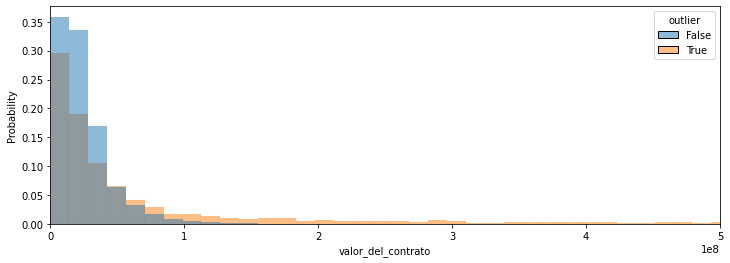

<IPython.core.display.Javascript object>

In [150]:
fig, ax = plt.subplots()
sns.histplot(
    data=df_contractors,
    x="valor_del_contrato",
    bins=5500,
    hue="outlier",
    stat="probability",
    common_norm=False,
    ax=ax,
    multiple="layer",
)
ax.set_xlim(0, 500000000)
fig.set_size_inches(12, 4)

In [172]:
df_contractors.rename(
    {
        "date_duration_max_open_contracts": "max_active_contracts",
        "index_count": "number_contracts",
    },
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

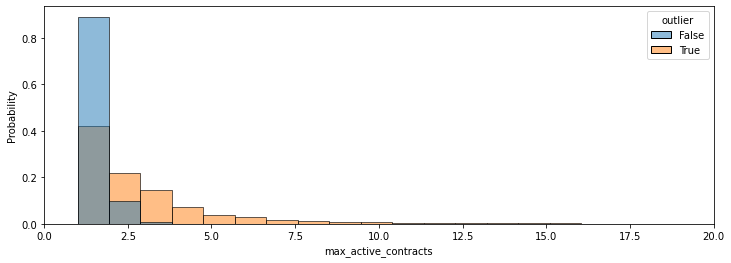

<IPython.core.display.Javascript object>

In [170]:
fig, ax = plt.subplots()
sns.histplot(
    data=df_contractors,
    x="max_active_contracts",
    bins=50,
    hue="outlier",
    stat="probability",
    common_norm=False,
    ax=ax,
    multiple="layer",
)
ax.set_xlim(0, 20)
fig.set_size_inches(12, 4)

As the different distributions show, the algorithm resulted in outliers with more expensive contracts and that hold multiple contracts at the same time. This results are promising as high values of these 2 indicators for people are worth investigating. The following table shows 15 of highlighted providers as outliers.

In [178]:
df_contractors[df_contractors["outlier"]][
    [
        "proveedor_adjudicado",
        "documento_proveedor",
        "number_contracts",
        "max_active_contracts",
        "valor_del_contrato",
    ]
].head(15)

,proveedor_adjudicado,documento_proveedor,number_contracts,max_active_contracts,valor_del_contrato
68,consorcio conurma-rincon-lopez,1321804,2,2,1.961389e+09
100,luis fernando mosquera largacha,1593099,3,3,1.952568e+08
127,armando enrique carrillo,1760916,2,2,2.080000e+08
264,az suministros,2253878,24,9,1.390179e+07
283,hernan beltran amortegui,2396872,34,8,1.433641e+07
335,enrique olaya rivera muñoz,2597480,21,4,2.986494e+07
382,alberto rafael toledo vergara,2757312,10,5,2.044264e+08
414,hernando de jesus echeverri zapata,2774335,7,5,2.576125e+07
450,antonio maria barrera carbonell,2944046,1,1,2.380000e+08
642,vicente hernan ramirez ruiz,2988561,3,3,1.863753e+08


<IPython.core.display.Javascript object>

The names of some of the providers like "az suministros" and "representaciones los cisnes" hints toward a data quality issue as these are not names of people but of companies. In further iterations these records should be corrected manually so that the analysis is not affected.

## Discusion

The colombian government open data initiatives are well thought and shine a light of transparency into otherwise considered obscure and corrupt institutions. Their efforts have constructed a centralized open dataset of public contracts available to the general public. These efforts must be applauded but have to improve in order to assure data quality as the databases are filled with contradicting information and inconsistencies. The harsh reality of the database was discovered through experimentation, produced reprocesses that delayed the initial cronogram shown below, and caused the dashboard to be postponed. It is very important to construct a tool to explore the model results in order to validate them and extract the full potential of the work.

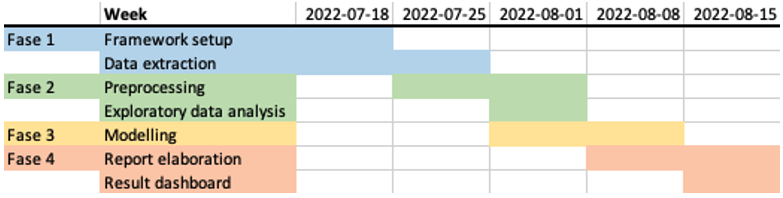

Most government agencies still use SECOP I, so it would be very useful to process the contracting information from that platform looking to deepen the analysis. The data quality of the dataset is a challenge, but in order to obtain a global understanding of public contracting in Colombia the additional information is required. <br>
The price model results could be improved considerably by including all the information of the contract instead of just the description. The processing and inclusion of this information is very complex, but it could also be very worthwhile as the information in the contract description is not enough to understand the tasks required by the contract.<br>
The DBSCAN results seem promising as it is classifying as outliers providers worth investigating, but in order to make sure that the highlighted providers present more irregularities than the ones not classified as outliers, a lot of further research is needed. It is also worthwile to investigate and charachterize the different clusters constructed by the DBSCAN algorithm in order to explore the regularities found by the algorithm.

## Conclusion

This project deepens the analysis of public contracting in Colombia from previous studies, and includes a data extraction and cleaning stage, an exploratory analysis of the SECOP II contracts dataset, the construction of a machine learning model that predicts contract value, and the use of the DBSCAN algorithm for outlier detection in contracting patterns. <br>
In this investigation it was found that the multiple public datasets about contracting are filled with inconsistencies and require a lot of cleaning and processing which ideally should be carried out by the Colombian government so that the datsets available are ready to use. It was also found that most of public contracts signed in Colombia are provision of services contracts under the figure of direct contracting, which is not advisable. The investigation also produced a price predicting model based on the contract description, and a set of outlier contractors that deserve further attention to check for possible irregularities.